In [9]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, LeakyReLU
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.utils import shuffle
from Bio import SeqIO
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt


# load test data
train_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/negative_sites.fasta')

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

In [8]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

### T-SNE for Prot-T5 based ANN Model

297/297 [==============================] - 1s 3ms/step


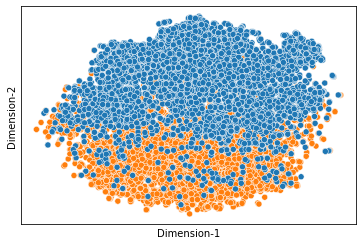

In [31]:
# load pretrained model
ANN_model = load_model('selected_models/ANN.h5')

# create truncated model
truncated_ANN_model = Model(inputs=ANN_model.input,
                                 outputs=ANN_model.get_layer(index=5).output)

hidden_features = truncated_ANN_model.predict(X_train_pt5)

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_ANN_protT5.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

### TSNE for Embedding Model

297/297 [==============================] - 1s 3ms/step


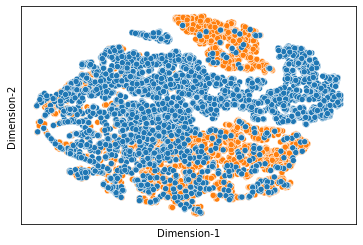

In [39]:
# load pretrained model
Embedding_model = load_model('selected_models/Embedding.h5')

# create truncated model
truncated_Embedding_model = Model(inputs=Embedding_model.input,
                                 outputs=Embedding_model.get_layer(index=7).output)

hidden_features = truncated_Embedding_model.predict(X_train_full_embedding)


df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_Embedding_After_Training.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

### TSNE for combined Model

297/297 [==============================] - 1s 4ms/step


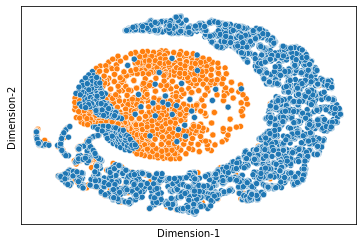

In [20]:
# load pretrained model
combined_model = load_model('selected_models/combined_feature_level.h5')

# create truncated model
truncated_combined_model = Model(inputs=combined_model.input,
                                 outputs=combined_model.get_layer(index=17).output)

hidden_features = truncated_combined_model.predict([X_train_full_embedding, X_train_pt5])

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 20)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_Combineda.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

297/297 [==============================] - 1s 4ms/step


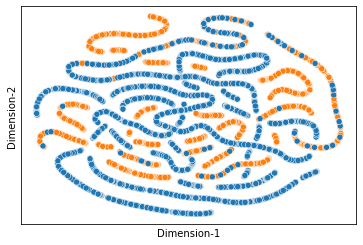

In [15]:
# load pretrained model
combined_model = load_model('selected_models/combined_feature_level_3626.h5')

# create truncated model
truncated_combined_model = Model(inputs=combined_model.input,
                                 outputs=combined_model.get_layer(index=16).output)

hidden_features = truncated_combined_model.predict([X_train_full_embedding, X_train_pt5])

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_Combined.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

In [19]:
combined_model.summary()

Model: "model_481"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_1838_input (InputLay  [(None, 33)]        0           []                               
 er)                                                                                              
                                                                                                  
 embedding_1838 (Embedding)     (None, 33, 21)       5376        ['embedding_1838_input[0][0]']   
                                                                                                  
 lambda_1825 (Lambda)           (None, 33, 21, 1)    0           ['embedding_1838[0][0]']         
                                                                                                  
 conv2d_1828 (Conv2D)           (None, 17, 19, 32)   1664        ['lambda_1825[0][0]']    

In [14]:
combined_model.summary()

Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_1838_input (InputLay  [(None, 33)]        0           []                               
 er)                                                                                              
                                                                                                  
 embedding_1838 (Embedding)     (None, 33, 21)       5376        ['embedding_1838_input[0][0]']   
                                                                                                  
 lambda_1825 (Lambda)           (None, 33, 21, 1)    0           ['embedding_1838[0][0]']         
                                                                                                  
 conv2d_1828 (Conv2D)           (None, 17, 19, 32)   1664        ['lambda_1825[0][0]']     

## TSNE Plot for empty models/ Before training

## Empty ANN

297/297 [==============================] - 1s 3ms/step


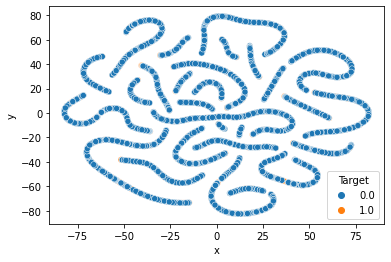

In [50]:
# load pretrained model
ANN_model = load_model('selected_models/empty_ANN.h5')

# create truncated model
truncated_ANN_model = Model(inputs=ANN_model.input,
                                 outputs=ANN_model.get_layer(index=5).output)

hidden_features = truncated_ANN_model.predict(X_train_pt5)

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 100)
tsne_features = m.fit_transform(hidden_features)
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
sns.scatterplot(x="x", y="y", hue='Target', data=df)
filename = "TSNE.png"
plt.savefig(filename, dpi=1600, bbox_inches='tight')
plt.show()

### Empty Embedding 

297/297 [==============================] - 1s 3ms/step


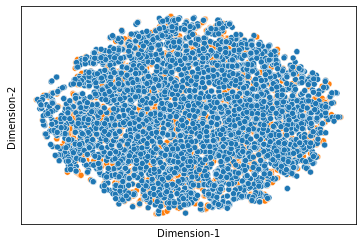

In [34]:
# load pretrained model
Embedding_model = load_model('selected_models/empty_Embedding.h5')

# create truncated model
truncated_Embedding_model = Model(inputs=Embedding_model.input,
                                 outputs=Embedding_model.get_layer(index=7).output)

hidden_features = truncated_Embedding_model.predict(X_train_full_embedding)

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_embedding_before_training.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

### Empty combined Model

297/297 [==============================] - 1s 4ms/step


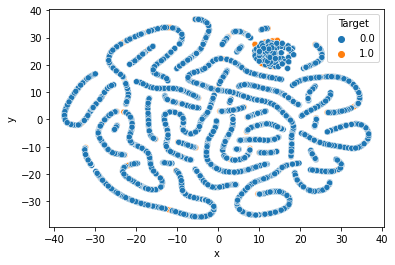

In [51]:
# load pretrained model
combined_model = load_model('selected_models/empty_combined.h5')

# create truncated model
truncated_combined_model = Model(inputs=combined_model.input,
                                 outputs=combined_model.get_layer(index=17).output)

hidden_features = truncated_combined_model.predict([X_train_full_embedding, X_train_pt5])

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
sns.scatterplot(x="x",y="y",hue='Target',data=df)
filename = "TSNE.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

297/297 [==============================] - 1s 4ms/step


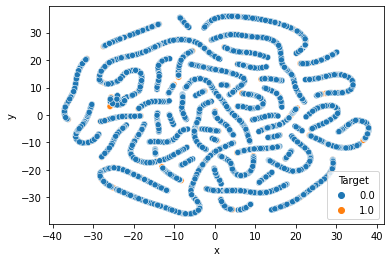

In [52]:
# load pretrained model
combined_model = load_model('selected_models/empty_combined_before_training_any_model.h5')

# create truncated model
truncated_combined_model = Model(inputs=combined_model.input,
                                 outputs=combined_model.get_layer(index=17).output)

hidden_features = truncated_combined_model.predict([X_train_full_embedding, X_train_pt5])

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(hidden_features)
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
sns.scatterplot(x="x",y="y",hue='Target',data=df)
filename = "TSNE.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

### ProtT5 Features

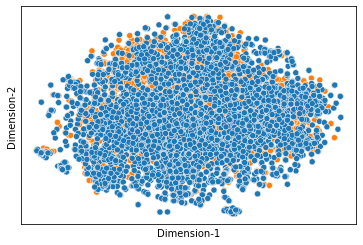

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns

df = pd.DataFrame()
df['Target'] = y_train_pt5

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform(X_train_pt5)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend().set_visible(False)
filename = "TSNE_only_protT5.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

### Draw Empty box

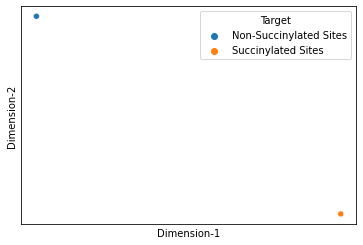

In [44]:
df = pd.DataFrame()
df['Target'] = ['Non-Succinylated Sites','Succinylated Sites']

m = TSNE(learning_rate = 10)
tsne_features = m.fit_transform([[1,2,3,4,5],[1,2,3,4,5]])
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
# plt.legend().set_visible(False)
filename = "TSNE empty box.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()